<a href="https://colab.research.google.com/github/sanjay2097/Sentiment-analysis-LSTM-GRU/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataframe
import numpy as np
import pandas as pd

# Plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D,MaxPooling1D, CuDNNLSTM, CuDNNGRU, MaxPooling1D, Bidirectional,SpatialDropout1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import gensim

# Utility
import re
import os
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy
spacy.cli.download('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
# Importing the dataset
df1 = pd.read_csv('/content/drive/MyDrive/practice_datasets/Train.csv')
df2 = pd.read_csv('/content/drive/MyDrive/practice_datasets/preprocessed_kindle_review .csv')

####Movie Review Dataset

In [4]:
df1.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
df1.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [6]:
df1['label'] = df1['label'].map({0:'negative',1:'positive'})
df1.columns = ['text','sentiment']

####Amazon Kindle Review

In [7]:
df2.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [8]:
#Function to map values
def cat(value):
  if value<=2:
    return 'negative'
  elif value==3:
    return 'neutral'
  else:
    return 'positive'
    
# Map categories
df2['rating']=df2['rating'].apply(lambda x : cat(x))
df2 = df2[['reviewText','rating']]
df2.columns = ['text','sentiment']

####Aggregated Data

In [9]:
df = pd.concat([df1, df2,], ignore_index=True)

In [10]:
df.head()

,text,sentiment
0,I grew up (b. 1965) watching and loving the Th...,negative
1,"When I put this movie in my DVD player, and sa...",negative
2,Why do people who do not know what a particula...,negative
3,Even though I have great interest in Biblical ...,negative
4,Im a die hard Dads Army fan and nothing will e...,positive


In [11]:
df.shape

(52000, 2)

In [12]:
df.sentiment.value_counts()

positive    25981
negative    24019
neutral      2000
Name: sentiment, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52000 entries, 0 to 51999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       52000 non-null  object
 1   sentiment  52000 non-null  object
dtypes: object(2)
memory usage: 812.6+ KB


###Text Preprocessing

In [14]:
# Define function for text cleaning
import re
def  clean_text(df, text_col):
    df[text_col] = df[text_col].str.lower()
    #remove punctuations and url text
    df[text_col] = df[text_col].apply(lambda x: re.sub(r"\n\n", " ", x))
    df[text_col] = df[text_col].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))  
    # remove numbers
    df[text_col] = df[text_col].apply(lambda x: re.sub(r"\d+", "", x))
    #remove extra spaces
    df[text_col] = df[text_col].apply(lambda x: x.replace('  ',' '))
    
    return df
# Applying function
df = clean_text(df,'text')
df.head(10)

,text,sentiment
0,i grew up b watching and loving the thunderbir...,negative
1,when i put this movie in my dvd player and sat...,negative
2,why do people who do not know what a particula...,negative
3,even though i have great interest in biblical ...,negative
4,im a die hard dads army fan and nothing will e...,positive
5,a terrible movie as everyone has said what mad...,negative
6,finally watched this shocking movie last night...,positive
7,i caught this film on azn on cable it sounded ...,negative
8,it may be the remake of autumns tale after ele...,positive
9,my super ex girlfriend turned out to be a plea...,positive


In [15]:
# list of stopwords from nltk
nltk.download('stopwords')
stopwords_nltk = list(stopwords.words('english'))

# list of stopwords from spacy
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)

#Custom stopwords
c_stop = ['br']

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(c_stop)
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
# all stop words
all_stopwords = list(set(all_stopwords))

def remove_stopwords(text):  
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
df['text'] = df['text'].apply(remove_stopwords)

In [17]:
# Remove duplicate values
df.drop_duplicates(inplace=True)

###EDA

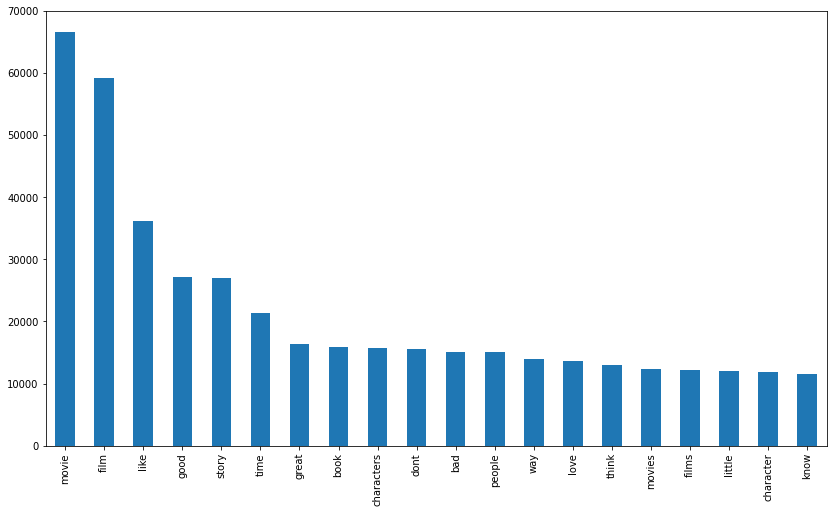

In [18]:
# bar plot of frequent words
plt.figure(figsize=(14,8))
pd.Series(' '.join(df['text']).split()).value_counts()[:20].plot.bar()
plt.show()

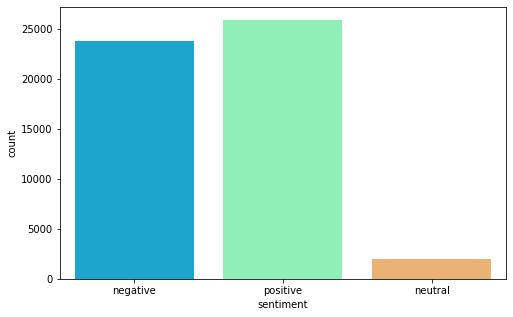

In [19]:
# The distribution of sentiments
plt.figure(figsize=(8,5))
ax = sns.countplot(x='sentiment',data=df,palette='rainbow')

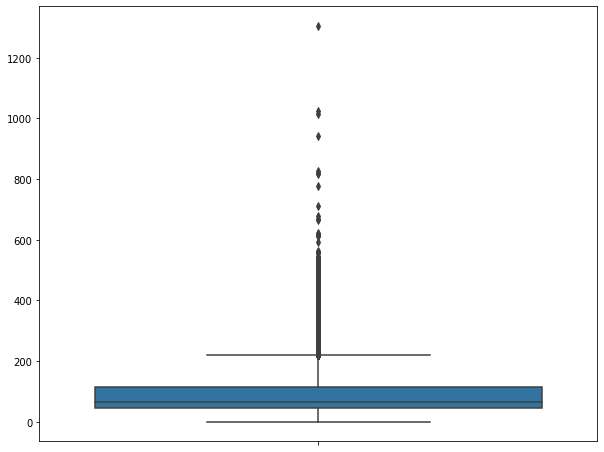

In [20]:
# Calculate tweet lengths
text_len = pd.Series([len(texts.split()) for texts in df['text']])

# The distribution of tweet text lengths
plt.figure(figsize=(10,8))
ax=sns.boxplot(y=text_len,data=df)

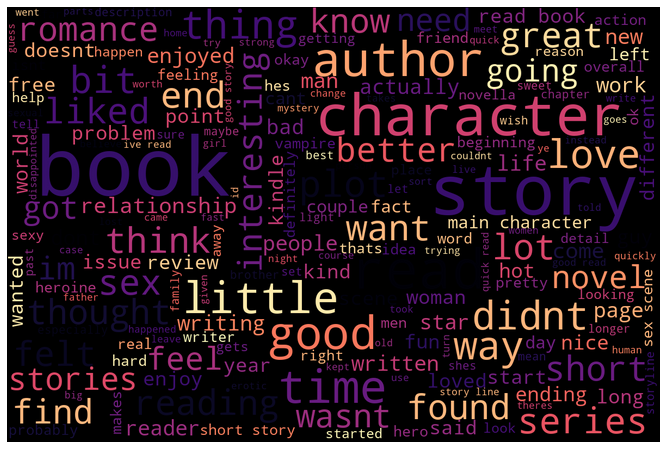

In [21]:
from wordcloud import WordCloud
## Neutral
words = " ".join([x for x in df.text[df.sentiment=='neutral']])

wordcloud = WordCloud(width=1200, height=800,max_font_size=150, colormap='magma').generate(words)

plt.figure(figsize=(14,8))
plt.imshow(wordcloud,interpolation='spline36')
plt.axis('off')
plt.show()

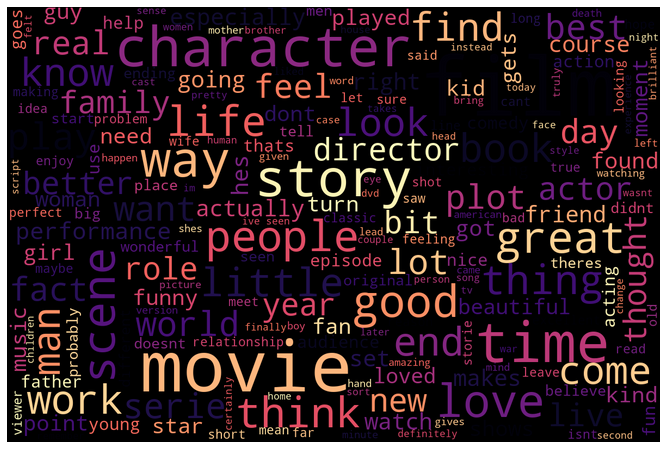

In [22]:
## Positive
words = " ".join([x for x in df.text[df.sentiment=='positive']])

wordcloud = WordCloud(width=1200, height=800,max_font_size=150, colormap='magma').generate(words)

plt.figure(figsize=(14,8))
plt.imshow(wordcloud,interpolation='spline36')
plt.axis('off')
plt.show()

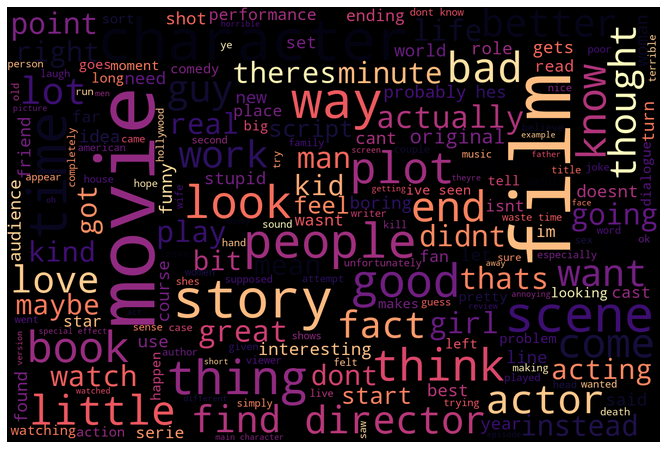

In [23]:
## Negative
words = " ".join([x for x in df.text[df.sentiment=='negative']])

wordcloud = WordCloud(width=1200, height=800,max_font_size=150, colormap='magma').generate(words)

plt.figure(figsize=(14,8))
plt.imshow(wordcloud,interpolation='spline36')
plt.axis('off')
plt.show()

In [24]:
# Create new column word count of sentence
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df.head()

,text,sentiment,word_count
0,grew b watching loving thunderbirds mates scho...,negative,76
1,movie dvd player sat coke chips expectations h...,negative,132
2,people know particular time past like feel nee...,negative,87
3,great interest biblical movies bored death min...,negative,27
4,im die hard dads army fan change got tapes dvd...,positive,88


Text(0, 0.5, 'Sentiment')

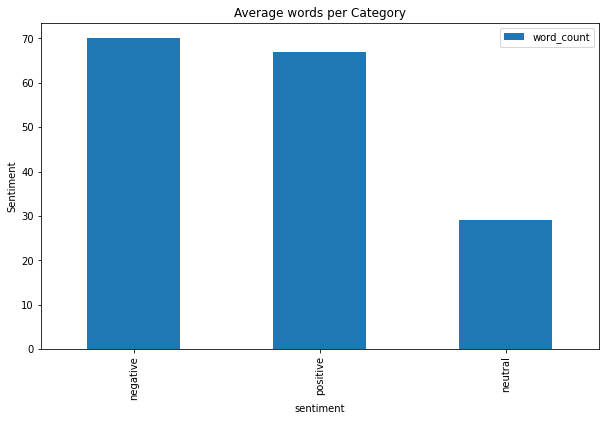

In [25]:
#average word count per category
pd.DataFrame(df.groupby(['sentiment'])['word_count'].agg(np.median).sort_values(ascending=False)).plot(kind='bar', figsize=(10,6),
              title = 'Average words per Category')
plt.ylabel('Sentiment')

In [26]:
df.drop(['word_count'],axis=1,inplace=True)

In [27]:
from gensim.utils import simple_preprocess
# Tokenize using gensims simple_preprocess
def sent_to_words(sentences, deacc=True):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

# convert to list
data=df['text'].values.tolist()
data_words=list(sent_to_words(data))

In [28]:
words_list = list(np.concatenate(data_words).flat)
print(f'Total Unique words in dataset are : {len(set(words_list))}')

Total Unique words in dataset are : 166241


###Lemmatization

In [29]:
# Functions for lemmatization
def lemmatization(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """
    https://spacy.io/api/annotation
    
    """
    texts_out=[]
    for sent in texts:
        doc=nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
#lemmatize
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
X = lemmatization(data_words,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

###Tokenization and Padding

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len=100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len, truncating='post')
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding :\n',df['text'][0])
X, tokenizer = tokenize_pad_sequences(df['text'])
print('After Tokenization & Padding :\n',X[0])

Before Tokenization & Padding :
 grew b watching loving thunderbirds mates school watched played thunderbirds school lunch school wanted virgil scott wanted alan counting art form took children movie hoping glimpse loved child bitterly disappointing high point snappy theme tune compare original score thunderbirds thankfully early saturday mornings television channel plays reruns series gerry anderson wife created jonatha frakes hand directors chair version completely hopeless waste film utter rubbish cgi remake acceptable replacing marionettes homo sapiens subsp sapiens huge error judgment
After Tokenization & Padding :
 [1729  758   47 1223 9313 3030  210  146  119 9313  210 5005  210  208
  922  208 1582 7533  390  581  298  295    1  957 2715  144  357 1033
  157   80 7747  578 2980 1365   85  435 9313 2197  239 2184  557 1078
  150 5844   40 2289  185  799  394  552 2864  167  166 4499  257    2
 1811 1789 1497  857 3157 9314  415 4886 5334    0    0    0    0    0
    0    0    0 

In [32]:
# Encode target labels
y = pd.get_dummies(df['sentiment'])

###Split Train and Test Data

In [33]:
# Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print('Train Set :', X_train.shape, y_train.shape)
print('Validation Set :', X_val.shape, y_val.shape)
print('Test Set :', X_test.shape, y_test.shape)

Train Set : (41890, 100) (41890, 3)
Validation Set : (4655, 100) (4655, 3)
Test Set : (5172, 100) (5172, 3)


###LSTM Model

In [34]:
from keras.backend import dropout
vocab_size = 10000
embedding_size = 32
epochs=5

# Build model
model1= Sequential()
model1.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model1.add(Dropout(0.2))

model1.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Bidirectional(CuDNNLSTM(32)))
model1.add(Dropout(0.2))

model1.add(Dense(3, activation='softmax'))

In [35]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16896     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [36]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=1)

# Compile model
model1.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy'])

# Train model

batch_size = 64
history = model1.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs,callbacks=[reduce_lr], verbose=1)

Epoch 1/5
655/655 [==============================] - 11s 10ms/step - loss: 0.5325 - accuracy: 0.7688 - val_loss: 0.4085 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 2/5
655/655 [==============================] - 6s 9ms/step - loss: 0.3481 - accuracy: 0.8643 - val_loss: 0.4009 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 3/5
655/655 [==============================] - 6s 9ms/step - loss: 0.2890 - accuracy: 0.8891 - val_loss: 0.4206 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 4/5
655/655 [==============================] - 6s 9ms/step - loss: 0.2005 - accuracy: 0.9291 - val_loss: 0.4749 - val_accuracy: 0.8331 - lr: 1.0000e-04
Epoch 5/5
655/655 [==============================] - 6s 9ms/step - loss: 0.1845 - accuracy: 0.9366 - val_loss: 0.4821 - val_accuracy: 0.8324 - lr: 1.0000e-05


In [37]:
# Evaluate model on the test set
loss, accuracy = model1.evaluate(X_test, y_test, batch_size=64)

81/81 [==============================] - 0s 5ms/step - loss: 0.4749 - accuracy: 0.8403


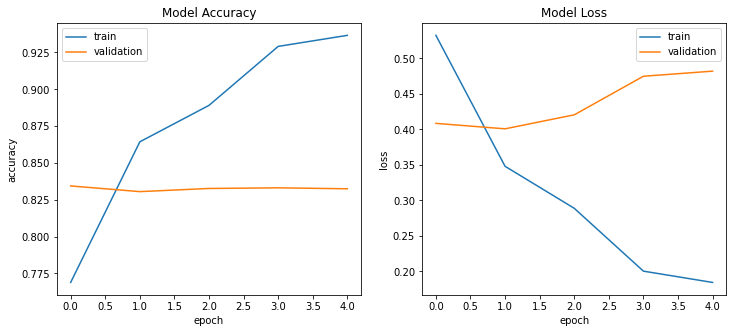

In [38]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

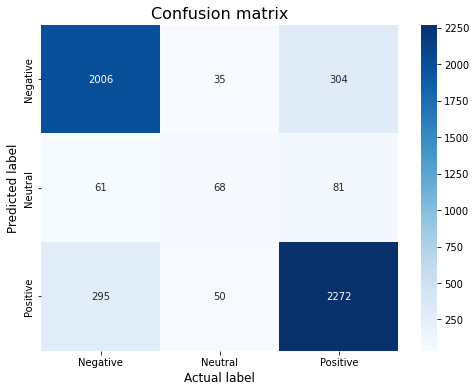

In [39]:
# Function for plotting confusion matrix
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model1, X_test, y_test)

###GRU Model

In [40]:
# Build model
model2= Sequential()

model2.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model2.add(SpatialDropout1D(0.2))

model2.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))

model2.add(Bidirectional(CuDNNGRU(32)))
model2.add(Dropout(0.2))

model2.add(Dense(3, activation='softmax'))

In [41]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 32)          0         
 ropout1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12672     
 nal)                                                            
                                                      

In [42]:
# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy'])

# Train model
batch_size = 64
history = model2.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs,callbacks=[reduce_lr], verbose=1)

Epoch 1/5
655/655 [==============================] - 7s 9ms/step - loss: 0.5531 - accuracy: 0.7493 - val_loss: 0.4109 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 2/5
655/655 [==============================] - 6s 9ms/step - loss: 0.3512 - accuracy: 0.8642 - val_loss: 0.4159 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 3/5
655/655 [==============================] - 6s 9ms/step - loss: 0.2498 - accuracy: 0.9099 - val_loss: 0.4322 - val_accuracy: 0.8331 - lr: 1.0000e-04
Epoch 4/5
655/655 [==============================] - 6s 8ms/step - loss: 0.2326 - accuracy: 0.9158 - val_loss: 0.4360 - val_accuracy: 0.8322 - lr: 1.0000e-05
Epoch 5/5
655/655 [==============================] - 6s 8ms/step - loss: 0.2314 - accuracy: 0.9190 - val_loss: 0.4367 - val_accuracy: 0.8324 - lr: 1.0000e-06


In [43]:
# Evaluate model on the test set
loss, accuracy = model2.evaluate(X_test, y_test, batch_size=64)

81/81 [==============================] - 0s 5ms/step - loss: 0.4259 - accuracy: 0.8399


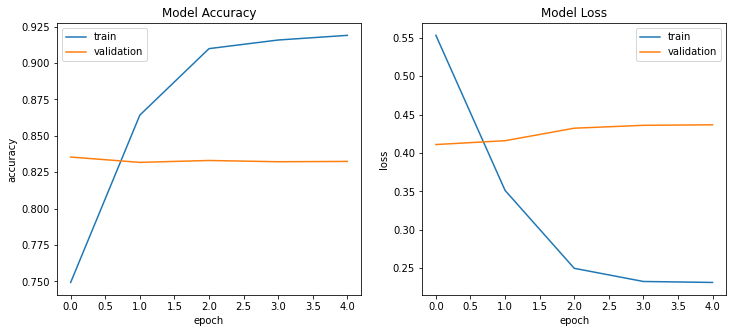

In [44]:
# Accuracy and loss plot
plot_training_hist(history)

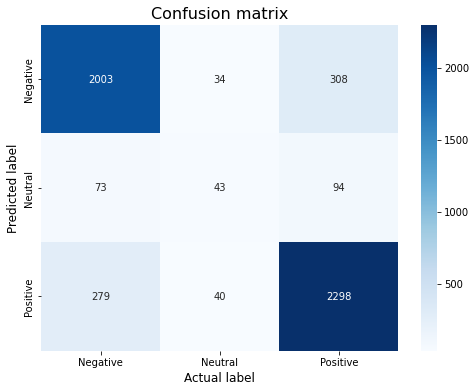

In [45]:
#Confusion Matrix
plot_confusion_matrix(model2, X_test, y_test)

###**Both the models are performing with almost similar accuarcy so we have a choice to use either of them.**

In [46]:
# Save the best model architecture & the weights
model2.save('best_model.h5')

###Load Best Model

In [47]:
from keras.models import load_model
# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=100
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [48]:
predict_class(['we are satisfied with our results'])

The predicted sentiment is Positive
